In [2]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import time
import pickle 

In [10]:
def mnist2():
    
    mnist = tf.keras.datasets.mnist #28x28 images of handwritten digits 0-9
    (x_train,y_train), (x_test,y_test) = mnist.load_data()
    x_train = x_train.reshape(-1,28*28)/255.0
    x_test = x_test.reshape(-1,28*28)/255.0
    
    def onehot(integer_labels):
            #Return matrix whose rows are onehot encodings of integers.
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehotL = np.zeros((n_rows, n_cols), dtype='uint8')
            onehotL[np.arange(n_rows), integer_labels] = 1
            return onehotL
        
    y_train = onehot(y_train)
    y_test = onehot(y_test)
    
    return x_train, y_train, x_test, y_test


In [5]:
def fashion_mnist():
    
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    
    train_images = train_images.reshape(-1,28*28)/255.0
    test_images = test_images.reshape(-1,28*28)/255.0
    
    def onehot(integer_labels):
            #Return matrix whose rows are onehot encodings of integers.
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehotL = np.zeros((n_rows, n_cols), dtype='uint8')
            onehotL[np.arange(n_rows), integer_labels] = 1
            return onehotL
        
    train_labels = onehot(train_labels)
    test_labels = onehot(test_labels)
    
    return train_images, train_labels, test_images, test_labels


In [3]:
def findclosest(K):
    sqrt = K**0.5
    
    def factors(n):
        return set(
            factor for i in range(1, int(n**0.5) + 1) if n % i == 0
            for factor in (i, n//i)
        )

    list1 = list(factors(K))
    list1 = np.array(list1)
    difference = abs(sqrt - list1)
    K1 = list1[np.argmin(difference)]
    K2 = int(K/K1)
    return K1,K2

In [35]:
def estimate_alpha_mohammed(X):
    mohammed = lambda Y,X: (1/np.log(abs(K_1)))*((1/K_2)*sum(np.log(abs(Y))) - (1/K)*sum(np.log(abs(X))))
    
    K = len(X)
    K_1,K_2 = findclosest(K)
    
    
    Y = np.zeros(K_2)
    for i in range(K_2):
        Y[i] = sum((X[j+(i-1)*K_1] for j in range(K_1)))
    alpha_k = 1/mohammed(Y,X)
    return alpha_k

In [68]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
d_sigmoid = lambda y: y * (1 - y)
#np.seterr(divide = 'ignore')

def feed_forward(X, weights):
    a = [X]
    for w in weights:
        a.append(np.maximum(a[-1].dot(w),0)) # Using ReLU
        #a.append(sigmoid(a[-1].dot(w)))     # Using sigmoid
    return a

def grads(X, Y, weights):
    grads = np.empty_like(weights)
    a = feed_forward(X, weights)
    delta = a[-1] - Y
    grads[-1] = a[-2].T.dot(delta)
    for i in range(len(a)-2, 0, -1):
        delta = (a[i] > 0) * delta.dot(weights[i].T) #Grad of ReLU exist for x>0
        #delta = np.dot(delta, weights[i].T) * d_sigmoid(a[i]) # Using Sigmoid
        grads[i-1] = a[i-1].T.dot(delta)
    return grads / len(X)

  
start = time.perf_counter()

trX, trY, teX, teY = fashion_mnist()   #outputs the data flattened and normalized 
input_dim = 784
neurons_hidden_layer = 100
output_dim = 10
train_length = len(trX)


weights = [np.random.randn(*w) * 0.1 for w in [(input_dim, neurons_hidden_layer), (neurons_hidden_layer, output_dim)]] #creates a tensor
num_epochs, batch_size, learn_rate = 10, 500, 0.1

estimate_alpha = np.zeros(num_epochs)
estimate_alpha_test = np.zeros(num_epochs)

for k in range(num_epochs):
    if (k+1)%5==0:
        print(f'Epoch:{k+1}')
    
    GD_gradient = grads(trX,trY,weights)[1]
    GD_gradient = GD_gradient.reshape(-1,neurons_hidden_layer*output_dim)[0]
    #old_weights = weights #since we need to do w_l not w_k^i
    
    each_minibatch_gradients = []
    each_test_minibatch_gradients = []
    
    for j in range(0, len(trX), batch_size):
        X_batch, Y_batch = trX[j:j+batch_size], trY[j:j+batch_size]
        
        both_weights_gradients = grads(X_batch, Y_batch, weights)
        
        batch_gradients = both_weights_gradients[1] #100x10 #old_weights
        each_minibatch_gradients.append(batch_gradients.reshape(-1,neurons_hidden_layer*output_dim)[0]) #after flattening
        
        weights -= learn_rate * both_weights_gradients
        
    stochastic_gradient_noise = GD_gradient - each_minibatch_gradients
    stochastic_gradient_noise = stochastic_gradient_noise.reshape(-1) #flattening it to a single vector K=hidden_neuronxoutput_dimx(ceiling(n/b))
    
    for j in range(0,len(teX),batch_size):
        X_test_batch, Y_test_batch = teX[j:j+batch_size], teY[j:j+batch_size]
        
        both_test_weights_gradients = grads(X_test_batch, Y_test_batch, weights)
        
        batch_test_gradients = both_test_weights_gradients[1] #100x10 #old_weights
        each_test_minibatch_gradients.append(batch_test_gradients.reshape(-1,neurons_hidden_layer*output_dim)[0]) #after flattening
    
    stochastic_test_gradient_noise = GD_gradient - each_test_minibatch_gradients
    stochastic_test_gradient_noise = stochastic_test_gradient_noise.reshape(-1) #flattening it to a single vector K=hidden_neuronxoutput_dimx(ceiling(n/b))
    
    try:
        alpha_k = estimate_alpha_mohammed(stochastic_gradient_noise)
        alpha_test_k = estimate_alpha_mohammed(stochastic_test_gradient_noise)
    
    except Exception as e:
        print('log error occured')
        alpha_k = estimate_alpha[k-1]
        alpha_test_k = estimate_alpha_test[k-1]
        
    estimate_alpha[k] = alpha_k
    estimate_alpha_test[k] = alpha_test_k
    
    if (k+1)%5==0:
        print(f'alpha_train{k+1}: {alpha_k}')
        print(f'alpha_test{k+1}: {alpha_test_k}')
    
        prediction = np.argmax(feed_forward(teX, weights)[-1], axis=1)
        print ('Epoch',k+1, 'Accuracy',100*np.mean(prediction == np.argmax(teY, axis=1)))
        print('')
end = time.perf_counter()
print(f'Wall Time: {round(end-start,3)} secs \n')



Epoch:5
alpha_train5: 0.0
alpha_test5: 0.0
Epoch 5 Accuracy 80.12

Epoch:10
alpha_train10: 0.0
alpha_test10: 0.0
Epoch 10 Accuracy 82.27

Wall Time: 30.251 secs 



In [39]:
pickle_out = open(f'relu_Estimate_alpha_train_epoch{num_epochs}.pickle','wb')  #create a file X.pickle 
pickle.dump(estimate_alpha,pickle_out)
pickle_out.close()

pickle_out = open(f'relu_Estimate_alpha_test_epoch{num_epochs}.pickle','wb')  #create a file X.pickle 
pickle.dump(estimate_alpha_test,pickle_out)
pickle_out.close()

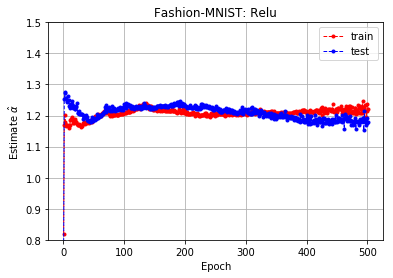

In [3]:
num_epochs = 500

Epoch = np.arange(1,num_epochs+2)
estimate_alpha_train = pickle.load(open(f'Fashion_MNIST_activation/relu_Estimate_alpha_train_epoch{num_epochs}.pickle','rb'))
estimate_alpha_test = pickle.load(open(f'Fashion_MNIST_activation/relu_Estimate_alpha_test_epoch{num_epochs}.pickle','rb'))


plt.plot(Epoch,estimate_alpha_train,'--.r',linewidth = 1,label='train');
plt.plot(Epoch,estimate_alpha_test,'--.b',linewidth = 1,label='test');
plt.xlabel(r'Epoch');
plt.ylabel(r'Estimate $\hat{\alpha}$');
plt.grid()
plt.legend()
plt.title('Fashion-MNIST: Relu')
plt.ylim([0.8,1.5])
plt.savefig(f'Fashion_MNIST_activation/relu_graph_epoch{num_epochs}.png', format='png', dpi=1200)

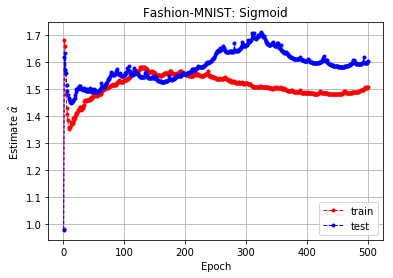

In [4]:
num_epochs = 500

Epoch = np.arange(1,num_epochs+1)
estimate_alpha_train = pickle.load(open(f'Fashion_MNIST_activation/sigmoid_Estimate_alpha_train_epoch{num_epochs}.pickle','rb'))
estimate_alpha_test = pickle.load(open(f'Fashion_MNIST_activation/sigmoid_Estimate_alpha_test_epoch{num_epochs}.pickle','rb'))

plt.plot(Epoch,estimate_alpha_train,'--.r',linewidth = 1,label='train');
plt.plot(Epoch,estimate_alpha_test,'--.b',linewidth = 1,label='test');
plt.xlabel(r'Epoch');
plt.ylabel(r'Estimate $\hat{\alpha}$');
plt.grid()
plt.legend()
plt.title('Fashion-MNIST: Sigmoid')
plt.savefig(f'Fashion_MNIST_activation\sigmoid_graph_epoch{num_epochs}.png', format='png', dpi=1200)

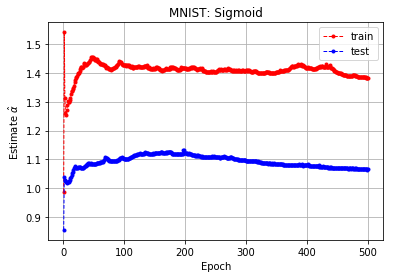

In [5]:
num_epochs = 500

Epoch = np.arange(1,num_epochs+1)
estimate_alpha_train = pickle.load(open(f'MNIST_activation/sigmoid_Estimate_alpha_train_epoch{num_epochs}.pickle','rb'))
estimate_alpha_test = pickle.load(open(f'MNIST_activation/sigmoid_Estimate_alpha_test_epoch{num_epochs}.pickle','rb'))

plt.plot(Epoch,estimate_alpha_train,'--.r',linewidth = 1,label='train');
plt.plot(Epoch,estimate_alpha_test,'--.b',linewidth = 1,label='test');
plt.xlabel(r'Epoch');
plt.ylabel(r'Estimate $\hat{\alpha}$');
plt.grid()
plt.legend()
plt.title('MNIST: Sigmoid')
plt.savefig(f'MNIST_activation/sigmoid_graph_epoch{num_epochs}.png', format='png', dpi=1200)

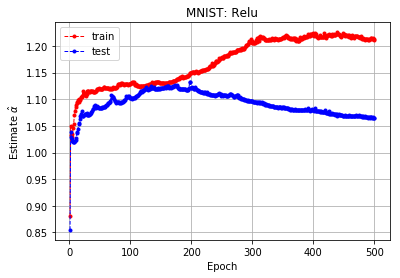

In [6]:
num_epochs = 500

Epoch = np.arange(1,num_epochs+1)
estimate_alpha_train = pickle.load(open(f'MNIST_activation/relu_Estimate_alpha_train_epoch{num_epochs}.pickle','rb'))
estimate_alpha_test = pickle.load(open(f'MNIST_activation/relu_Estimate_alpha_test_epoch{num_epochs}.pickle','rb'))

plt.plot(Epoch,estimate_alpha_train,'--.r',linewidth = 1,label='train');
plt.plot(Epoch,estimate_alpha_test,'--.b',linewidth = 1,label='test');
plt.xlabel(r'Epoch');
plt.ylabel(r'Estimate $\hat{\alpha}$');
plt.grid()
plt.legend()
plt.title('MNIST: Relu')
plt.savefig(f'MNIST_activation/relu_graph_epoch{num_epochs}.png', format='png', dpi=1200)

In [15]:
train_images, train_labels, test_images, test_labels = fashion_mnist()